In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import os

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

from scipy import stats as mstats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import KFold

!pip install mlflow

import kagglehub
path = kagglehub.dataset_download("dharun4772/doordash-eta-prediction")

In [142]:
print(os.listdir(os.getcwd()))
path = kagglehub.dataset_download('dharun4772/doordash-eta-prediction')

csv_file_path = os.path.join(path, 'historical_data.csv')

df = pd.read_csv(csv_file_path)

df.head()

['.config', 'sample_data']


,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


We’re working with a DoorDash dataset to predict food delivery times. The goal is to build a model that accurately estimates how long it takes from when an order is placed to when it's delivered. The data includes features like order details (number of items, subtotal), restaurant info, and market conditions (available dashers, outstanding orders). We also have timestamps for when the order was placed and delivered, which helps us calculate the delivery time.

We’re choosing the following features because they directly impact the complexity and timing of the delivery process:
*   total_items: More items in an order can lead to longer preparation and packaging times, which can delay the delivery.
*   num_distinct_items: A higher number of distinct items may require more coordination in the kitchen, increasing the order complexity and affecting delivery time.
total_onshift_dashers: The number of available dashers influences how
*   total_onshift_dashers: The number of available dashers influences how quickly an order can be assigned and delivered. More available dashers typically result in faster deliveries.
*   total_busy_dashers: If many dashers are already working on other orders, it can create delays in assigning a dasher to a new order, impacting delivery time.

In [143]:
# Convert to datetime objects
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df['created_at'] = pd.to_datetime(df['created_at'])

# Calculate the difference in minutes
df['delivery_time_minutes'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60
df.drop(['created_at', 'actual_delivery_time'], axis=1, inplace=True)

In [144]:
df.head(10)

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time_minutes
0,1.0,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,62.983333
1,2.0,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,67.066667
2,3.0,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,29.683333
3,3.0,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,51.250000
4,3.0,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,39.833333
5,3.0,5477,NaN,1.0,3,5000,3,1500,1900,2.0,2.0,2.0,446,338.0,38.333333
6,3.0,5477,NaN,1.0,2,3900,2,1200,2700,10.0,9.0,9.0,446,638.0,26.400000
7,3.0,5477,NaN,1.0,4,4850,4,750,1800,7.0,8.0,7.0,446,626.0,32.750000
8,2.0,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,26.433333
9,3.0,5477,NaN,1.0,2,2100,2,700,1200,2.0,2.0,2.0,446,715.0,53.200000


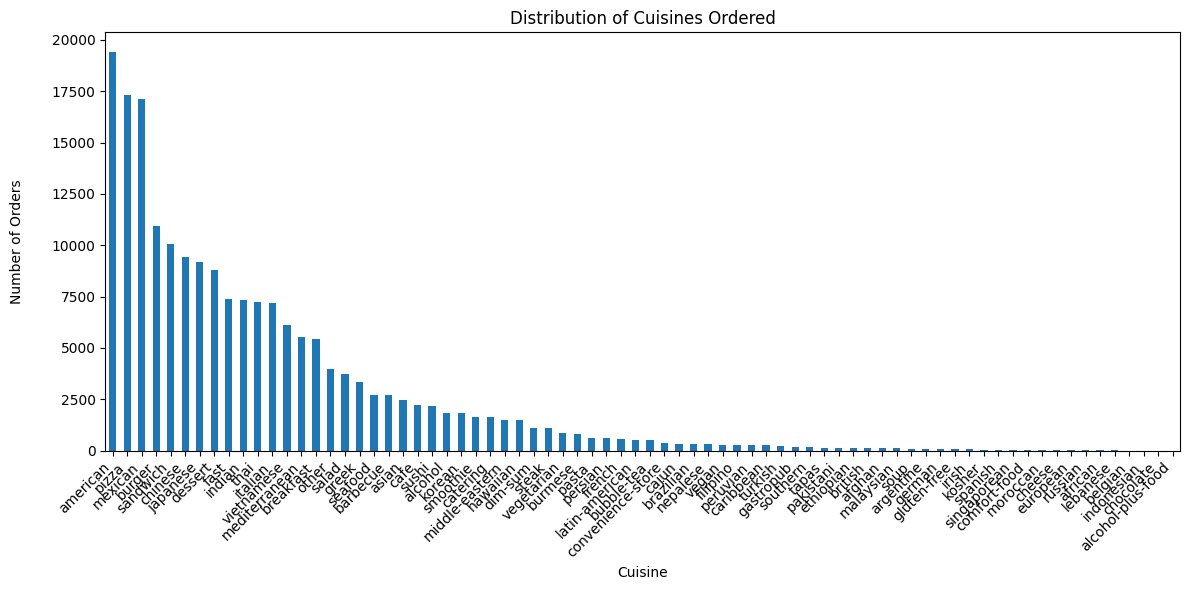

In [145]:
plt.figure(figsize=(12, 6))
df['store_primary_category'].value_counts().plot(kind='bar')
plt.title('Distribution of Cuisines Ordered')
plt.xlabel('Cuisine')
plt.ylabel('Number of Orders', labelpad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [146]:
nan_count = df['store_primary_category'].isna().sum()
print(f"Number of NaNs in 'store_primary_category': {nan_count}")

df = df.dropna(subset=['store_primary_category'])

Number of NaNs in 'store_primary_category': 4760


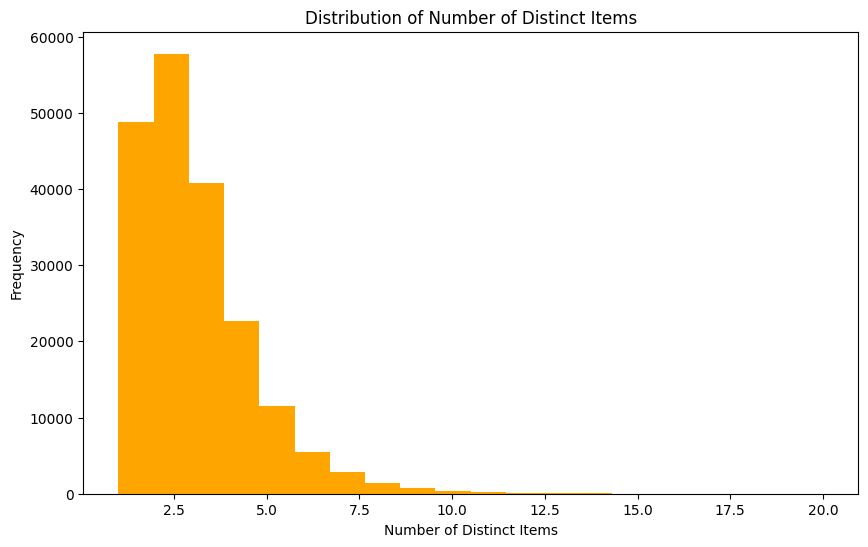

In [147]:
# Histograms for num_distinct_items and total_items
plt.figure(figsize=(10, 6))
plt.hist(df['num_distinct_items'], bins=20, color='orange')
plt.title('Distribution of Number of Distinct Items')
plt.xlabel('Number of Distinct Items')
plt.ylabel('Frequency')
plt.show()

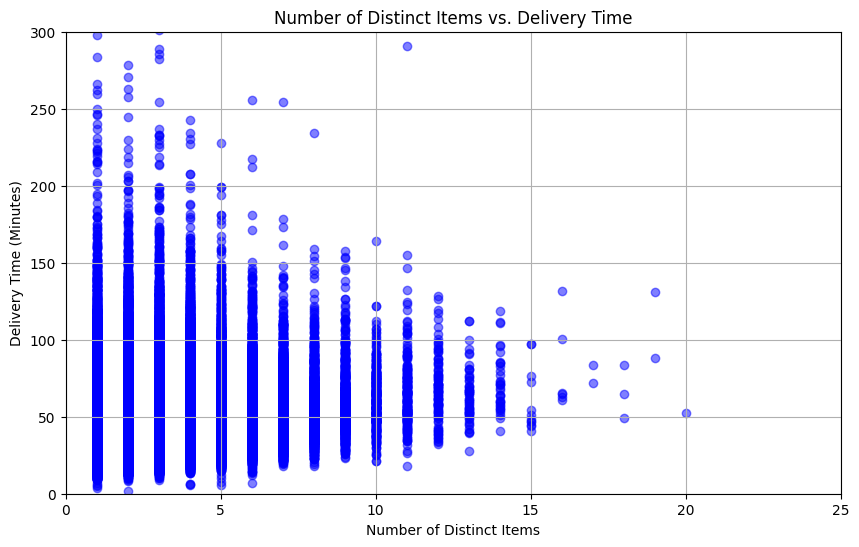

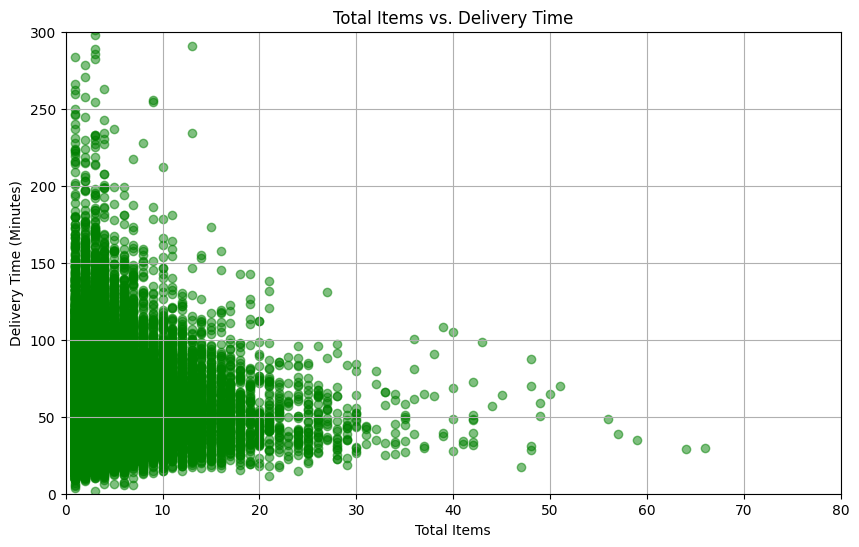

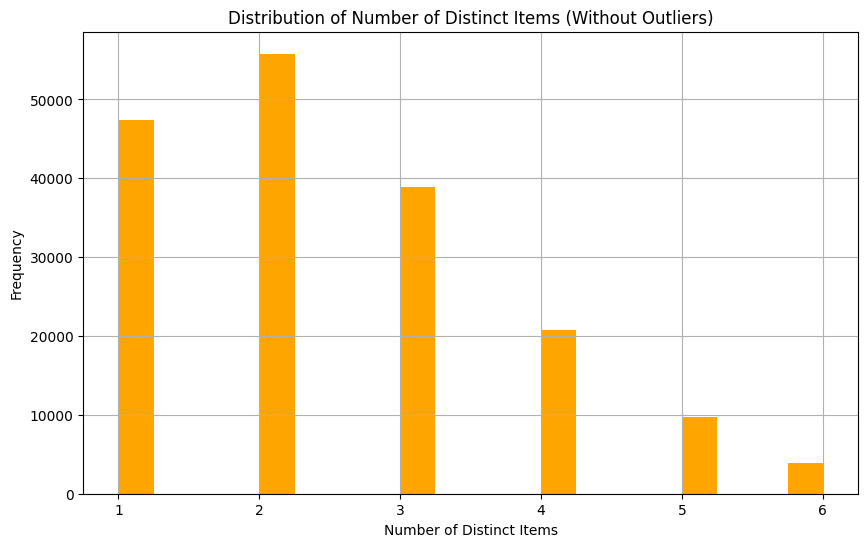

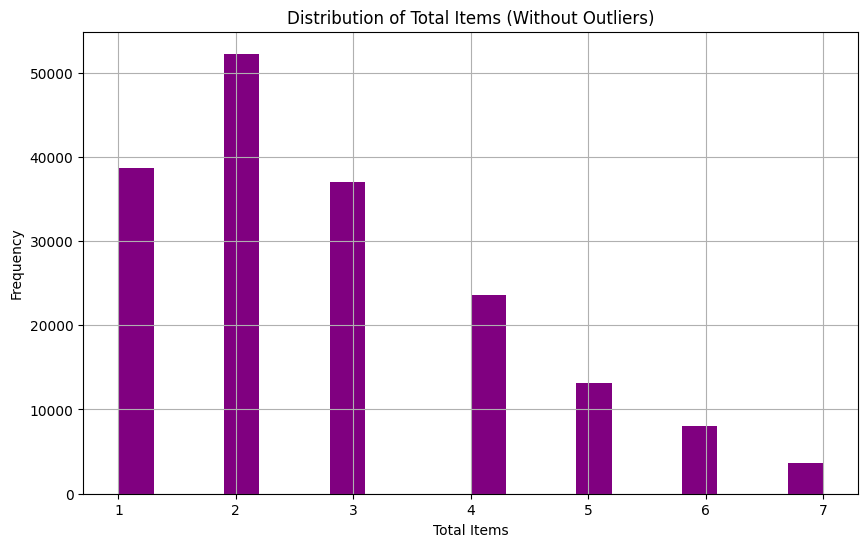

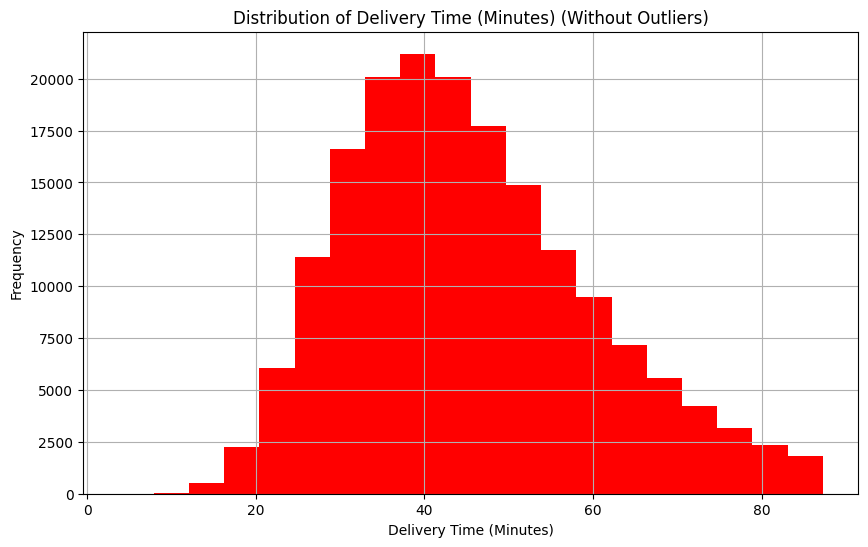

In [148]:
# Scatter plot: num_distinct_items vs. delivery_time_minutes
plt.figure(figsize=(10, 6))
plt.scatter(df['num_distinct_items'], df['delivery_time_minutes'], alpha=0.5, color='blue')
plt.title('Number of Distinct Items vs. Delivery Time')
plt.xlabel('Number of Distinct Items')
plt.ylabel('Delivery Time (Minutes)')
plt.grid(True)
plt.xlim(0,25)
plt.ylim(0,300)
plt.show()

# Scatter plot: total_items vs. delivery_time_minutes
plt.figure(figsize=(10, 6))
plt.scatter(df['total_items'], df['delivery_time_minutes'], alpha=0.5, color='green')
plt.title('Total Items vs. Delivery Time')
plt.xlabel('Total Items')
plt.ylabel('Delivery Time (Minutes)')
plt.xlim(0,80)
plt.ylim(0,300)
plt.grid(True)
plt.show()

# Remove outliers using the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_filtered = df.copy()
df_filtered = remove_outliers(df_filtered, 'num_distinct_items')
df_filtered = remove_outliers(df_filtered, 'total_items')
df_filtered = remove_outliers(df_filtered, 'delivery_time_minutes')

# Histograms for num_distinct_items and total_items without outliers
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['num_distinct_items'], bins=20, color='orange')
plt.title('Distribution of Number of Distinct Items (Without Outliers)')
plt.xlabel('Number of Distinct Items')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(df_filtered['total_items'], bins=20, color='purple')
plt.title('Distribution of Total Items (Without Outliers)')
plt.xlabel('Total Items')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Histogram for delivery_time_minutes without outliers
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['delivery_time_minutes'], bins=20, color='red')
plt.title('Distribution of Delivery Time (Minutes) (Without Outliers)')
plt.xlabel('Delivery Time (Minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [149]:
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

missing_proportion = df.isnull().mean() * 100
print("\nMissing Value Proportion (%):\n", missing_proportion)

for column in df.select_dtypes(include=np.number).columns:
  print(f"Range for '{column}': [{df[column].min()}, {df[column].max()}]")

Missing Values:
 market_id                                         495
store_id                                            0
store_primary_category                              0
order_protocol                                    488
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           15717
total_busy_dashers                              15717
total_outstanding_orders                        15717
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      515
delivery_time_minutes                               7
dtype: int64

Missing Value Proportion (%):
 market_id                                       0.256919
store_id                                        0.000000
store_primary_

In [150]:
X = df_filtered[['total_items', 'num_distinct_items', 'total_onshift_dashers', 'total_busy_dashers']]
y = df_filtered['delivery_time_minutes']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 141072
Validation set size: 35269


In [151]:
columns_to_drop = ['estimated_store_to_consumer_driving_duration', 'estimated_order_place_duration', 'min_item_price', 'max_item_price', 'market_id', 'store_id', 'store_primary_category', 'order_protocol']
df_filtered = df_filtered.drop(columns=columns_to_drop)

df_filtered = df_filtered.reset_index(drop = True)
df_filtered

,total_items,subtotal,num_distinct_items,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,delivery_time_minutes
0,4,3441,4,33.0,14.0,21.0,62.983333
1,1,1900,1,1.0,2.0,2.0,67.066667
2,4,4771,3,8.0,6.0,18.0,26.433333
3,1,1525,1,5.0,6.0,8.0,37.883333
4,2,3620,2,5.0,5.0,7.0,49.800000
...,...,...,...,...,...,...,...
176336,3,1389,3,17.0,17.0,23.0,65.116667
176337,6,3010,4,12.0,11.0,14.0,56.383333
176338,5,1836,3,39.0,41.0,40.0,50.133333
176339,1,1175,1,7.0,7.0,12.0,65.116667


In [152]:
df_filtered['Busyness Percentage'] = (df_filtered['total_busy_dashers'] / df_filtered['total_onshift_dashers'])

new_df = df_filtered.drop(['total_busy_dashers', 'total_onshift_dashers'], axis=1)

new_df = new_df[['total_items', 'num_distinct_items', 'Busyness Percentage', 'subtotal', 'total_outstanding_orders', 'delivery_time_minutes']]

In [153]:
final_df = new_df[~new_df['Busyness Percentage'].isin([np.inf, -np.inf])]

In [154]:
final_df['delivery_time_binary'] = (final_df['delivery_time_minutes'] >= 30).astype(int)

cleaned_df = final_df.dropna()
cleaned_df

<ipython-input-154-3951c4e0f76d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['delivery_time_binary'] = (final_df['delivery_time_minutes'] >= 30).astype(int)


,total_items,num_distinct_items,Busyness Percentage,subtotal,total_outstanding_orders,delivery_time_minutes,delivery_time_binary
0,4,4,0.424242,3441,21.0,62.983333,1
1,1,1,2.000000,1900,2.0,67.066667,1
2,4,3,0.750000,4771,18.0,26.433333,0
3,1,1,1.200000,1525,8.0,37.883333,1
4,2,2,1.000000,3620,7.0,49.800000,1
...,...,...,...,...,...,...,...
176336,3,3,1.000000,1389,23.0,65.116667,1
176337,6,4,0.916667,3010,14.0,56.383333,1
176338,5,3,1.051282,1836,40.0,50.133333,1
176339,1,1,1.000000,1175,12.0,65.116667,1


In [155]:
X = cleaned_df[['total_items', 'num_distinct_items', 'Busyness Percentage',  'subtotal', 'total_outstanding_orders']]
y = cleaned_df['delivery_time_minutes']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=21)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=21)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

Training set size: 127160
Validation set size: 31790


**Metric**

We used Mean Squared Error and Mean Absolute Error for observing how the model is doing, but in terms of actually fitting the model and analysing learning rates, we only used MSE to heavily penalize large errors in delivery times as the scale of delivery times isn't that high in the first place ranging from 10 minutes to 60 minutes.

**Training Process**

First we normalize the data, then fit the model on that for 3 epochs (discretionary decision) and then after re-scale to calculate performance metrics and analyse the training process based on the MSE loss function.

As for our learning rate, we referenced the method talked about in class where you choose 1/2 * maximal_LR which is the maximum LR for when validation loss starts to diverge, which we saw in the previous code segment. After selecting this LR, the NN was trained over 12 epochs, and as shown in the graph above we saw the val loss decrease sharply during the first 3 epochs then start to plateau.

Given that delivery times are prone to noise from real world circumstances we also wanted to train a classification neural network in order to create more broad categories from which we can predict the delivery time. The three category's we decided upon was Short (<15 minutes), Medium (15-30 minutes), and Long (>30 minutes).

Testing learning rate: 0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7347 - loss: 0.7136 - val_accuracy: 0.8576 - val_loss: 0.4067
Epoch 2/3
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8600 - loss: 0.4150 - val_accuracy: 0.8576 - val_loss: 0.3901
Epoch 3/3
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8585 - loss: 0.4035 - val_accuracy: 0.8576 - val_loss: 0.3862
Testing learning rate: 0.0005
Epoch 1/3
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8308 - loss: 0.5016 - val_accuracy: 0.8576 - val_loss: 0.3837
Epoch 2/3
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8583 - loss: 0.3928 - val_accuracy: 0.8576 - val_loss: 0.3817
Epoch 3/3
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8589 - loss: 0.3889 - val_accuracy: 0.8576 - val_loss: 0.3808
Testing learning rate: 0.001
Epoch 1/3
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8501 - loss: 0.4493 - val_accuracy: 0.8576 - val_loss: 0.3818
Epoch 2/3
1739/1739 ━━━━━━━━━━━━━━━━━

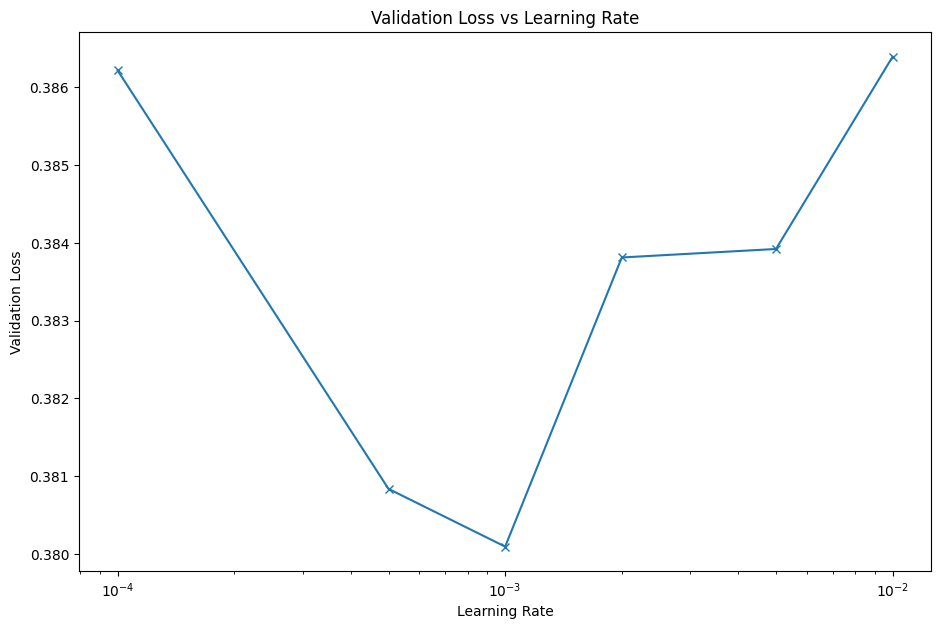

In [156]:
# Prepare features and target
X = cleaned_df[['total_items', 'num_distinct_items', 'Busyness Percentage', 'subtotal', 'total_outstanding_orders']]
y = cleaned_df['delivery_time_minutes']

# Categorize target values
y_categories = pd.cut(y, bins=[0, 15, 30, np.inf], labels=['Short', 'Medium', 'Long'])

# Encode target categories
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_categories)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=21)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=21)

# Scale the features
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)

# List of learning rates to test
learning_rates = [0.0001, 0.0005, 0.001, 0.002, 0.005, 0.01]

# List to store final validation losses
val_losses = []

# Define the model architecture
def create_model():
    model = Sequential([
        Dense(64, activation='relu', input_dim=X_train.shape[1]),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    return model

# Train and evaluate the model for each learning rate
for lr in learning_rates:
    print(f"Testing learning rate: {lr}")
    model = create_model()
    model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=3,
        batch_size=64,
        verbose=1
    )

    # Store the final validation loss
    final_loss = history.history['val_loss'][-1]
    val_losses.append(final_loss)

# Plot validation loss against learning rates
plt.figure(figsize=(11, 7))
plt.plot(learning_rates, val_losses, marker='x')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Learning Rate')
plt.show()

The above graph depicts code we used to find what the best learning rate would be. We used a variety of learning rates eventually narrowing it down to the following range in which the global minima is as well as where the learning rate begins to rise again.

Now we applied the learning rate to the data set and added a couple of different features to enhance the models ability to detect trends and relationships. We also added a method to handle outliers. We defined callbacks that would reduce learning rate if the model hit a plateau and added early stopping as well as dropout to avoid overfitting.

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.8323 - loss: 0.8237 - val_accuracy: 0.8598 - val_loss: 0.4019 - learning_rate: 0.0020
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8600 - loss: 0.4066 - val_accuracy: 0.8598 - val_loss: 0.3950 - learning_rate: 0.0020
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.8609 - loss: 0.3985 - val_accuracy: 0.8598 - val_loss: 0.3935 - learning_rate: 0.0020
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8576 - loss: 0.4024 - val_accuracy: 0.8597 - val_loss: 0.3884 - learning_rate: 0.0020
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8596 - loss: 0.3980 - val_accuracy: 0.8598 - val_loss: 0.3927 - learning_rate: 0.0020
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8622 - loss: 0.3935 - val_accuracy: 0.8598 - val_loss: 0.3867 - learning_rate: 0.0020
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8577 - loss:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Test Set Metrics:
Precision: 0.7372
Recall: 0.8586
F1 Score: 0.7933
MAE: 2.15 minutes
MSE: 32.94 minutes²


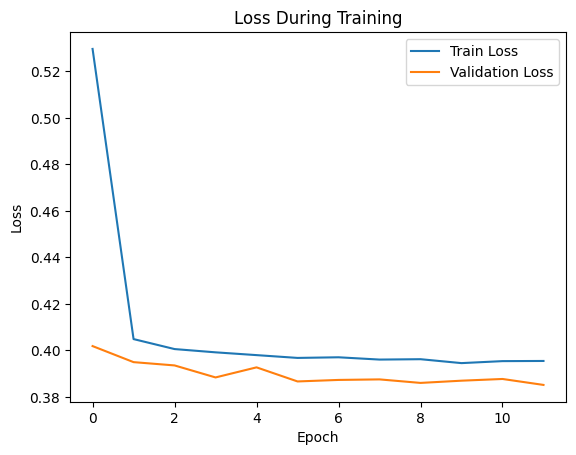

In [157]:
# Prepare features and target
X = cleaned_df[['total_items', 'num_distinct_items', 'Busyness Percentage', 'subtotal', 'total_outstanding_orders']].copy()
y = cleaned_df['delivery_time_minutes']

# Create interaction features
X['subtotal_per_item'] = X['subtotal'] / (X['total_items'] + 1)
X['busyness_item_ratio'] = X['Busyness Percentage'] / (X['total_items'] + 1)

# # Handle outliers
# X['subtotal'] = mstats.winsorize(X['subtotal'], limits=[0.01, 0.01])

# Categorize target values
y_categories = pd.cut(y, bins=[0, 15, 30, np.inf], labels=['Short', 'Medium', 'Long'])

# Encode target categories
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_categories)

# Scale the features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=21)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=21)

#define model
def create_model():
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_dim=X.shape[1]),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(3, activation='softmax')  # 3 output classes: Short, Medium, Long
    ])
    model.compile(optimizer=Adam(learning_rate=0.002),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# Initialize the model
model = create_model()

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=12,
                    batch_size=32,
                    callbacks=[reduce_lr, early_stopping],
                    verbose=1)

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Calculate classification metrics
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Convert predictions to delivery times for regression metrics
y_test_actual = [15 if label == 0 else 30 if label == 1 else 45 for label in y_test]
y_pred_actual = [15 if label == 0 else 30 if label == 1 else 45 for label in y_pred_classes]

# Calculate regression metrics
mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)

# Display metrics
print(f"\nTest Set Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MAE: {mae:.2f} minutes")
print(f"MSE: {mse:.2f} minutes²")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss During Training')
plt.show()

Finally we implement cross validation here with kfold using 5 different folds to validate our models accurace over multiple test and validation splits as opposed to just basing our assumption of the models accuracy off of a singular test.

In [158]:
# Set up K-Fold Cross-Validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=21)

# Lists to store performance metrics
precision_scores = []
recall_scores = []
f1_scores = []
mae_scores = []
mse_scores = []

# Train and evaluate the model for each fold
for fold, (train_index, val_index) in enumerate(kf.split(X_scaled)):
    print(f"\nTraining Fold {fold + 1}/{k}")

    # Split data into training and validation sets
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y_encoded[train_index], y_encoded[val_index]

    # Create and compile the model
    model = create_model()

    # Train the model
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=20,
                        batch_size=64,
                        callbacks=[reduce_lr, early_stopping],
                        verbose=1)

    # Predict on the validation set
    y_pred_prob = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred_prob, axis=1)

    # Calculate classification metrics
    precision = precision_score(y_val, y_pred_classes, average='weighted')
    recall = recall_score(y_val, y_pred_classes, average='weighted')
    f1 = f1_score(y_val, y_pred_classes, average='weighted')

    # Convert predicted and actual classes to delivery times
    y_val_actual = [15 if label == 0 else 30 if label == 1 else 45 for label in y_val]
    y_pred_actual = [15 if label == 0 else 30 if label == 1 else 45 for label in y_pred_classes]

    # Calculate regression metrics
    mae = mean_absolute_error(y_val_actual, y_pred_actual)
    mse = mean_squared_error(y_val_actual, y_pred_actual)

    # Store the metrics
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    mae_scores.append(mae)
    mse_scores.append(mse)

    print(f"Fold {fold + 1} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, MAE: {mae:.2f}, MSE: {mse:.2f}")

# Display average metrics across all folds
print("\nCross-Validation Results:")
print(f"Average Precision: {np.mean(precision_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f}")
print(f"Average F1 Score: {np.mean(f1_scores):.4f}")
print(f"Average MAE: {np.mean(mae_scores):.2f} minutes")
print(f"Average MSE: {np.mean(mse_scores):.2f} minutes²")


Training Fold 1/5
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1987/1987 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.8382 - loss: 0.8400 - val_accuracy: 0.8580 - val_loss: 0.3958 - learning_rate: 0.0020
Epoch 2/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8597 - loss: 0.4017 - val_accuracy: 0.8580 - val_loss: 0.3926 - learning_rate: 0.0020
Epoch 3/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8597 - loss: 0.3988 - val_accuracy: 0.8580 - val_loss: 0.3924 - learning_rate: 0.0020
Epoch 4/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8618 - loss: 0.3932 - val_accuracy: 0.8580 - val_loss: 0.3916 - learning_rate: 0.0020
Epoch 5/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8585 - loss: 0.3979 - val_accuracy: 0.8581 - val_loss: 0.3888 - learning_rate: 0.0020
994/994 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Fold 1 - Precision: 0.7363, Recall: 0.8580, F1 Score: 0.7925, MAE: 2.15, MSE: 32.98

Training Fold 2/5
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1987/1987 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8495 - loss: 0.7374 - val_accuracy: 0.8608 - val_loss: 0.3974 - learning_rate: 0.0020
Epoch 2/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8595 - loss: 0.4013 - val_accuracy: 0.8608 - val_loss: 0.3918 - learning_rate: 0.0020
Epoch 3/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8591 - loss: 0.3985 - val_accuracy: 0.8608 - val_loss: 0.3910 - learning_rate: 0.0020
Epoch 4/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8581 - loss: 0.3990 - val_accuracy: 0.8608 - val_loss: 0.3896 - learning_rate: 0.0020
Epoch 5/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8602 - loss: 0.3936 - val_accuracy: 0.8608 - val_loss: 0.3886 - learning_rate: 0.0020
994/994 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Fold 2 - Precision: 0.7410, Recall: 0.8608, F1 Score: 0.7965, MAE: 2.11, MSE: 32.33

Training Fold 3/5
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1987/1987 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8451 - loss: 0.8254 - val_accuracy: 0.8623 - val_loss: 0.3972 - learning_rate: 0.0020
Epoch 2/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8589 - loss: 0.4026 - val_accuracy: 0.8623 - val_loss: 0.3920 - learning_rate: 0.0020
Epoch 3/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8588 - loss: 0.3989 - val_accuracy: 0.8623 - val_loss: 0.3881 - learning_rate: 0.0020
Epoch 4/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8587 - loss: 0.3967 - val_accuracy: 0.8623 - val_loss: 0.3908 - learning_rate: 0.0020
Epoch 5/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.8590 - loss: 0.3940 - val_accuracy: 0.8623 - val_loss: 0.3867 - learning_rate: 0.0020
994/994 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Fold 3 - Precision: 0.7436, Recall: 0.8623, F1 Score: 0.7986, MAE: 2.09, MSE: 32.30

Training Fold 4/5
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1987/1987 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8400 - loss: 0.7936 - val_accuracy: 0.8577 - val_loss: 0.3989 - learning_rate: 0.0020
Epoch 2/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8583 - loss: 0.4042 - val_accuracy: 0.8577 - val_loss: 0.3971 - learning_rate: 0.0020
Epoch 3/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8601 - loss: 0.3961 - val_accuracy: 0.8577 - val_loss: 0.3990 - learning_rate: 0.0020
Epoch 4/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8612 - loss: 0.3934 - val_accuracy: 0.8577 - val_loss: 0.3939 - learning_rate: 0.0020
Epoch 5/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8606 - loss: 0.3927 - val_accuracy: 0.8577 - val_loss: 0.3924 - learning_rate: 0.0020
994/994 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Fold 4 - Precision: 0.7357, Recall: 0.8577, F1 Score: 0.7920, MAE: 2.16, MSE: 33.27

Training Fold 5/5
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1987/1987 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8301 - loss: 0.8524 - val_accuracy: 0.8584 - val_loss: 0.3977 - learning_rate: 0.0020
Epoch 2/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8584 - loss: 0.4034 - val_accuracy: 0.8583 - val_loss: 0.3981 - learning_rate: 0.0020
Epoch 3/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8592 - loss: 0.3992 - val_accuracy: 0.8584 - val_loss: 0.3929 - learning_rate: 0.0020
Epoch 4/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8598 - loss: 0.3943 - val_accuracy: 0.8583 - val_loss: 0.3933 - learning_rate: 0.0020
Epoch 5/20
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8595 - loss: 0.3949 - val_accuracy: 0.8584 - val_loss: 0.3929 - learning_rate: 0.0020
994/994 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Fold 5 - Precision: 0.7369, Recall: 0.8584, F1 Score: 0.7930, MAE: 2.15, MSE: 33.17

Cross-Validation Results:
Average Precision: 0.7387
Average Recall: 0.8595
Average F1 Score: 0.7945
Average MAE: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
